In [305]:
from copy import copy, deepcopy
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split 
from sklearn import metrics

import sklearn.linear_model
import pandas as pd 
import numpy as np
import sys
import re
%matplotlib inline

In [306]:
# Load the Wine Dataset
df_wine = pd.read_csv("../data/winemag-data-130k-v2.csv", encoding = 'utf8', index_col=0)
df_wine = df_wine.reset_index()

In [307]:
print(df_wine.dtypes)

index                      int64
country                   object
description               object
designation               object
points                     int64
price                    float64
province                  object
region_1                  object
region_2                  object
taster_name               object
taster_twitter_handle     object
title                     object
variety                   object
winery                    object
dtype: object


# REGION CHECK

In [308]:
df_wine["region"] = df_wine["region_2"].fillna(df_wine["region_1"])

In [309]:
df_wine = df_wine[['country','province','region','price','title','variety','points']]

In [310]:
# Finding the number of rows with NULL values
df_wine.isnull().sum()

country        63
province       63
region      21247
price        8996
title           0
variety         1
points          0
dtype: int64

In [311]:
# DROP rows with NULL values
df_wine=df_wine.dropna()
df_wine.shape

(101400, 7)

In [312]:
df_wine['points'].describe()

count    101400.000000
mean         88.463343
std           3.060467
min          80.000000
25%          86.000000
50%          88.000000
75%          91.000000
max         100.000000
Name: points, dtype: float64

In [313]:
# GET DUMMY VARIABLES
from sklearn.preprocessing import LabelEncoder
#Auto encodes any dataframe column of type category or object.
def dummyEncode(df):
        columnsToEncode = list(df.select_dtypes(include=['category','object']))
        le = LabelEncoder()
        for feature in columnsToEncode:
            try:
                df[feature] = le.fit_transform(df[feature])
            except:
                print('Error encoding '+feature)
        return df

In [314]:
df_dummy = dummyEncode(df_wine[['country','province','region','variety']])
df_dummy.columns = ['country_num', 'province_num','region_num','variety_num']
df_wine = pd.concat([df_wine, df_dummy], axis=1)
df_wine.head(5)

/anaconda2/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


,country,province,region,price,title,variety,points,country_num,province_num,region_num,variety_num
2,US,Oregon,Willamette Valley,14.0,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,87,6,43,1009,318
3,US,Michigan,Lake Michigan Shore,13.0,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,87,6,30,477,347
4,US,Oregon,Willamette Valley,65.0,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,87,6,43,1009,322
5,Spain,Northern Spain,Navarra,15.0,Tandem 2011 Ars In Vitro Tempranillo-Merlot (N...,Tempranillo-Merlot,87,5,39,639,430
6,Italy,Sicily & Sardinia,Vittoria,16.0,Terre di Giurfo 2013 Belsito Frappato (Vittoria),Frappato,87,4,50,999,131


# Extracting Year from Title

In [315]:
# REGEX: Extract first numbers from Title - FAILED BECAUSE THERE ARE MANY NUMBERS IN TITLES
df = pd.DataFrame(df_wine['title'])
df['year'] = df['title'].str.extract('(\d+)')
df.year.unique()

array(['2013', '2012', '2011', '2010', '2007', '2009', '2014', '2015',
       nan, '2016', '2', '2004', '2003', '2006', '2008', '2001', '2005',
       '2002', '9', '46', '1887', '2000', '1999', '1991', '1997', '772',
       '1', '41', '42', '44', '14', '33', '2017', '1637', '35', '39',
       '1996', '4', '3', '012', '401', '181', '1492', '1898', '1998',
       '7200', '1852', '50', '7', '12', '66', '1995', '1994', '1992',
       '18401', '15', '5', '6', '1929', '240', '075', '17', '1875', '22',
       '10', '786', '21', '8', '38', '351', '460', '1856', '91', '29',
       '24', '25', '1990', '1988', '154', '511', '1827', '1860', '45',
       '735', '1872', '52', '109', '204', '150', '1850', '337', '1877',
       '30', '310', '1870', '100', '205', '1000', '1868', '16', '103',
       '585', '413', '1989', '1993', '360', '32', '20', '1882', '51',
       '375', '1821', '47', '158', '69', '128', '1947', '13', '1070',
       '1985', '1927', '1904', '68', '1847', '1982', '1986', '90', '736',


In [316]:
# FUNCTION: FIND ALL NUMBERS IN THE TITLE, ADD THEM TO A LIST VARIABLE
def regex(x):
    L = re.findall(r'\d+', str(x))
    L_str = ",".join(str(x) for x in L)
    return str(L_str)

In [317]:
df['title_num_values'] = df['title'].apply(regex)

In [318]:
# FINDING HOW MANY NUMBERS DOES EACH TITLE INCLUDE
df['num_count'] = df.title_num_values.str.count(',') + 1
numeric_values_ct = df.num_count.max()
df.head()

,title,year,title_num_values,num_count
2,Rainstorm 2013 Pinot Gris (Willamette Valley),2013,2013,1
3,St. Julian 2013 Reserve Late Harvest Riesling ...,2013,2013,1
4,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,2012,2012,1
5,Tandem 2011 Ars In Vitro Tempranillo-Merlot (N...,2011,2011,1
6,Terre di Giurfo 2013 Belsito Frappato (Vittoria),2013,2013,1


In [319]:
# FOR ALL THE NUMERIC VALUES IN THE TITLES FIND THEM AND ADD TO A NEW DATA FRAME AS COLUMNS
def regex2(y):
    L = re.findall(r'\d+', str(y))
    X = np.array([L])
    new_L = []
    for x in X:
        a = x.tolist()
        b = []
        for i in range(1, numeric_values_ct + 1):
            if len(a) == numeric_values_ct:
                new_L.append(a)
                break
            else:
                for j in range(0, numeric_values_ct - len(a)):
                     b = a.extend([0])
    return new_L

In [320]:
xx = df['title'].apply(regex2)
new_list1 = []
new_list2 = []
new_list3 = []
new_list4 = []
new_list5 = []
for row in xx:
    new_list1.append(row[0][0])
    new_list2.append(row[0][1])
    new_list3.append(row[0][2])
    new_list4.append(row[0][3])
    new_list5.append(row[0][4])

In [321]:
df.insert(loc=0, column='N5', value= pd.Series(new_list5))
df.insert(loc=0, column='N4', value= pd.Series(new_list4))
df.insert(loc=0, column='N3', value= pd.Series(new_list3))
df.insert(loc=0, column='N2', value= pd.Series(new_list2))
df.insert(loc=0, column='N1', value= pd.Series(new_list1))

In [322]:
# SET 0 FOR ALL THE VALUES WHICH HAS MORE THAN 4 DIGIT
df.loc[df['N1'].astype(str).map(len) != 4 , 'N1'] = 0
df.loc[df['N2'].astype(str).map(len) != 4 , 'N2'] = 0
df.loc[df['N3'].astype(str).map(len) != 4 , 'N3'] = 0
df.loc[df['N4'].astype(str).map(len) != 4 , 'N4'] = 0
df.loc[df['N5'].astype(str).map(len) != 4 , 'N5'] = 0

# SET 0 FOR ALL THE VALUES GREATER THAN CURRENT YEAR
df.loc[df['N1'].astype(int) > 2018 , 'N1'] = 0
df.loc[df['N2'].astype(int) > 2018 , 'N2'] = 0
df.loc[df['N3'].astype(int) > 2018 , 'N3'] = 0
df.loc[df['N4'].astype(int) > 2018 , 'N4'] = 0
df.loc[df['N5'].astype(int) > 2018 , 'N5'] = 0

In [323]:
df['year_of_wine'] = df[['N5','N4','N3','N2','N1']].astype(int).max(axis=1)

In [324]:
# DELETE ALL THE YEARS BEFORE 1900 
df = df[['title', 'year_of_wine']]
df.loc[df['year_of_wine']  < 1900 , 'year_of_wine'] = 0
df.year_of_wine.unique()

array([2012, 2011, 2013, 2010, 2007, 2009, 2014, 2015,    0, 2016, 2004,
       2003, 2006, 2008, 2001, 2005, 2000, 1999, 1991, 2002, 1997, 2017,
       1996, 1998, 1995, 1994, 1992, 1990, 1989, 1993, 1947, 1988, 1927,
       1904, 1982, 1985, 1987, 1978, 1986, 1945])

In [325]:
# CONCAT THE YEAR COLUMN TO MAIN DATAFRAME
try:
    if 'year_of_wine' not in df_wine:
        df_wine = pd.concat([df_wine, df.year_of_wine], axis=1)
except (RuntimeError, TypeError, NameError):
    print("Error: concating year to main dataframe")

In [326]:
df_wine.head(3)

,country,province,region,price,title,variety,points,country_num,province_num,region_num,variety_num,year_of_wine
2,US,Oregon,Willamette Valley,14.0,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,87,6,43,1009,318,2012
3,US,Michigan,Lake Michigan Shore,13.0,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,87,6,30,477,347,2011
4,US,Oregon,Willamette Valley,65.0,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,87,6,43,1009,322,2013


# Convert categorical variables to numeric with One Hot Encoding

In [327]:
# Variety
df_variety = df_wine.variety.str.get_dummies()
df_variety.columns = ['v_' + col for col in df_variety.columns] # naming the columns
df_wine = pd.concat([df_wine, df_variety], axis=1) # combine main dataframe with country matrix dataframe
df_wine = df_wine.drop('variety', axis=1) # drop the country attribute since different attributes per country value
df_wine = df_wine.drop('variety_num', axis=1) # drop the country attribute since different attributes per country value

In [328]:
# Country
df_country = df_wine.country.str.get_dummies() # get the pivot of the country attribte
df_country.columns = ['country_' + col for col in df_country.columns] # naming the columns
df_wine = pd.concat([df_wine, df_country], axis=1) # combine main dataframe with country matrix dataframe
df_wine = df_wine.drop('country', axis=1) # drop the country attribute since different attributes per country value
df_wine = df_wine.drop('country_num', axis=1) # drop the country attribute since different attributes per country value

In [329]:
# Province
df_province = df_wine.province.str.get_dummies() # get the pivot of the country attribte
df_province.columns = ['province_' + col for col in df_province.columns] # naming the columns
df_wine = pd.concat([df_wine, df_province], axis=1) # combine main dataframe with country matrix dataframe
df_wine = df_wine.drop('province', axis=1) # drop the country attribute since different attributes per country value
df_wine = df_wine.drop('province_num', axis=1) # drop the country attribute since different attributes per country value

In [330]:
# Region
#df_region = df_wine.region.str.get_dummies() # get the pivot of the country attribte
#df_region.columns = ['region_' + col for col in df_province.columns] # naming the columns
#df_wine = pd.concat([df_wine, df_region], axis=1) # combine main dataframe with country matrix dataframe
df_wine = df_wine.drop('region', axis=1) # drop the country attribute since different attributes per country value
df_wine = df_wine.drop('region_num', axis=1) # drop the country attribute since different attributes per country value


# Data Preparation

In [331]:
# DEFINE X and Y VARIABLES
df_wine = df_wine[df_wine['year_of_wine'] > 0]
df_X = df_wine.drop('points', axis=1)
df_X = df_X.drop('title', axis=1) # year was already extracted
df_Y = df_wine[['points']]
print(df_X.shape)
print(df_Y.shape)

(76176, 583)
(76176, 1)


In [368]:
df_X = df_X2
df_Y = df_Y2

# Future Selection & Information Gain

In [369]:
# Feature Selection
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression

# Create and fit selector
selector = SelectKBest(f_regression, k=round(len(df_X.columns)/3))
selector.fit(df_X, df_Y)

mask = selector.get_support()
new_features = df_X.columns[mask]
print('# of cols before:', df_X.shape[1])
df_X = df_X[new_features]
print('# of cols after:', df_X.shape[1])

# of cols before: 583
# of cols after: 194


/anaconda2/envs/py3/lib/python3.6/site-packages/sklearn/utils/validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda2/envs/py3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:299: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda2/envs/py3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/anaconda2/envs/py3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/anaconda2/envs/py3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


In [378]:
# INFORMATION GAIN
from sklearn import linear_model

lm = linear_model.LinearRegression()
scores = []

num_features = len(df_X.columns)
for i in range(num_features):
    col = df_X.columns[i]
    scores_col = cross_val_score(lm, df_X[col].values.reshape(-1,1), df_Y.values.ravel(), cv=10, scoring='neg_mean_squared_error')
    best_score = np.mean(np.sqrt(-scores_col))
    scores.append((best_score, col))
    
scores = sorted(scores, reverse = False)
print('top 5 columns:', scores[0:5])

top 5 columns: [(2.771007061671871, 'price'), (3.0117181569967806, 'v_Pinot Noir'), (3.020919596039174, 'country_Argentina'), (3.021704214334636, 'country_Spain'), (3.025599340849671, 'province_Mendoza Province')]


In [391]:
# Split Data to Test and Traning
X_train, X_test, y_train, y_test = train_test_split(df_X, df_Y, test_size=0.33)

# Grid Search For Hyper Parameter Selection

In [449]:
# Best result without Hyperparameter optimisation
lm = linear_model.LinearRegression()

# Train the model using the training sets
lm.fit(X_train, y_train)

# Make predictions using the testing set
y_pred = lm.predict(X_test)

# The mean squared error
print("# Best result WITHOUT hyperparameter optimisation #")
print("RMSE: %.4f" % np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print("MAE: %.4f" % metrics.mean_absolute_error(y_test, y_pred))

# Best result WITHOUT hyperparameter optimisation #
RMSE: 2.6989
MAE: 2.0931


In [403]:
# Hyperparameter selection
lm = linear_model.LinearRegression()
parameters = {'fit_intercept':[True,False],
              'normalize':[True,False], 
              'copy_X':[True, False]}

gd_sr = GridSearchCV(estimator = lm,  
                     param_grid = parameters,
                     scoring = "neg_mean_squared_error",
                     cv = 10)

gd_sr.fit(X_train, y_train)  

best_parameters = gd_sr.best_params_  
print("Best Parameters:", best_parameters)

/anaconda2/envs/py3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best Parameters: {'copy_X': True, 'fit_intercept': False, 'normalize': True}


In [450]:
# Best result with Hyperparameter optimisation
lm = linear_model.LinearRegression(copy_X = True, fit_intercept = False, normalize = True)

# Train the model using the training sets
lm.fit(X_train, y_train)

# Make predictions using the testing set
y_pred = lm.predict(X_test)

# The mean squared error
print("# Best result WITH hyperparameter optimisation #")
print("RMSE: %.4f" % np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print("MAE: %.4f" % metrics.mean_absolute_error(y_test, y_pred))

# Best result WITH hyperparameter optimisation #
RMSE: 2.7047
MAE: 2.0983


# Outliers in Test Data

### Regression WITH outliers in Training data

In [432]:
# test sets also have outliers
lm = linear_model.LinearRegression()
model = lm.fit(X_train, y_train)
y_predictions_3 = lm.predict(X_test)

In [433]:
from copy import copy, deepcopy
# store results
ax3_y_test = deepcopy(y_test)
ax3_y_predictions = deepcopy(y_predictions_3)

In [434]:
# Root mean squared error (RMSE)
print('RMSE:', np.sqrt(metrics.mean_squared_error(ax3_y_test, ax3_y_predictions)))
mae_3 = np.sqrt(metrics.mean_squared_error(ax3_y_test, ax3_y_predictions))
mae_3 = metrics.mean_absolute_error(ax3_y_test, ax3_y_predictions)

RMSE: 2.698938605469962


### Regression W/O outliers in Training Data


In [435]:
# Clean test data
def reject_outliers(data, m=2):
    return data[abs(data - np.mean(data)) < m * np.std(data)]

# store clean training data
X_train_clean = deepcopy(X_train)
y_train_clean = deepcopy(y_train)

# remove outliers from training data
print("Training data with outliers", X_train_clean.shape, y_train_clean.shape)

training_prices_wo_outliers = reject_outliers(X_train_clean['price'].values)
# remove points from test set if price was an outlier
min_price = min(training_prices_wo_outliers)
max_price = max(training_prices_wo_outliers)


training_data = pd.concat([X_train_clean, y_train_clean], axis=1)
training_clean = training_data.drop(training_data[training_data.price < min_price].index)
training_clean = training_clean.drop(training_clean[training_clean.price > max_price].index)

X_train_outlier_clean = training_clean[training_clean.columns[:-1].tolist()]
y_train_outlier_clean = training_clean['points'].values.reshape(-1, 1)
print("Training data without outliers", X_train_outlier_clean.shape, y_train_outlier_clean.shape)

Training data with outliers (51037, 194) (51037, 1)
Training data without outliers (49782, 194) (49782, 1)


In [436]:
# apply linear regression again
lm = linear_model.LinearRegression()
model = lm.fit(X_train_outlier_clean, y_train_outlier_clean)
y_predictions_4 = lm.predict(X_test)

In [437]:
from copy import copy, deepcopy
# store results for chart 4
ax4_y_test = deepcopy(y_test)
ax4_y_predictions = deepcopy(y_predictions_4)

In [438]:
# Root mean squared error (RMSE)
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, ax4_y_predictions)))
mae_4 = np.sqrt(metrics.mean_squared_error(y_test, ax4_y_predictions))
mae_4 = metrics.mean_absolute_error(y_test, ax4_y_predictions)

RMSE: 3.697571996061573


### Clean outliers from Test Data

In [439]:
# store clean test data
X_test_clean = deepcopy(X_test)
y_test_clean = deepcopy(y_test)

In [440]:
############################# REMOVE OUTLIERS FROM TESTING ##########################
print("Test data with outliers", X_test_clean.shape, y_test_clean.shape)
# clean prices from testing
test_prices_wo_outliers = reject_outliers(X_test_clean.values)
# remove points from test set if price was an outlier
min_price = min(test_prices_wo_outliers)
max_price = max(test_prices_wo_outliers)

test_data = pd.concat([X_test, y_test], axis=1)
test_data_clean = test_data.drop(test_data[test_data.price < min_price].index)
test_data_clean = test_data_clean.drop(test_data_clean[test_data_clean.price > max_price].index)

X_test_outlier_clean = test_data_clean[test_data_clean.columns[:-1].tolist()]
y_test_outlier_clean = pd.DataFrame(test_data_clean['points'])
print("Test data without outliers", X_test_outlier_clean.shape, y_test_outlier_clean.shape)
#######################################################################################

Test data with outliers (25139, 194) (25139, 1)
Test data without outliers (25060, 194) (25060, 1)


### Regression WITH outliers in Training data


In [441]:
lm = linear_model.LinearRegression()
model = lm.fit(X_train, y_train) # dirty training
y_predictions_1 = lm.predict(X_test_outlier_clean) # clean test

In [442]:
from copy import copy, deepcopy
# store results
ax1_y_test = deepcopy(y_test_outlier_clean)
ax1_y_predictions = deepcopy(y_predictions_1)

In [443]:
# Root mean squared error (RMSE)
print('RMSE:', np.sqrt(metrics.mean_squared_error(ax1_y_test, ax1_y_predictions)))
mae_1 = np.sqrt(metrics.mean_squared_error(ax1_y_test, ax1_y_predictions))
mae_1 = metrics.mean_absolute_error(ax1_y_test, ax1_y_predictions)

RMSE: 2.566625812457663


### Regression W/O outliers in Training data

In [444]:
# apply linear regression again
lm = linear_model.LinearRegression()
model = lm.fit(X_train_outlier_clean, y_train_outlier_clean)
y_predictions_2 = lm.predict(X_test_outlier_clean)

In [445]:
from copy import copy, deepcopy
# store results
ax2_y_test = deepcopy(y_test_outlier_clean)
ax2_y_predictions = deepcopy(y_predictions_2)

In [446]:
# Root mean squared error (RMSE)
print('RMSE:', np.sqrt(metrics.mean_squared_error(ax2_y_test, y_predictions_2)))
mae_2 = np.sqrt(metrics.mean_squared_error(ax2_y_test, y_predictions_2))
mae_2 = metrics.mean_absolute_error(ax2_y_test, y_predictions_2)

RMSE: 2.5709474778686343


# SUMMARY

In [447]:
from IPython.display import HTML, display

data = [["Training\Test", "W/ OUTLIERS","W/O OUTLIERS"],
         ["W/ OUTLIERS",mae_3, mae_1],
         ["W/O OUTLIERS",mae_4, mae_2],
         ]

display(HTML(
    '<table><tr>{}</tr></table>'.format(
        '</tr><tr>'.join(
            '<td>{}</td>'.format('</td><td>'.join(str(_) for _ in row)) for row in data)
        )
 ))

Training\Test,W/ OUTLIERS,W/O OUTLIERS
W/ OUTLIERS,2.0930767439713795,2.0737660448492243
W/O OUTLIERS,2.0917146917572844,1.9943241567632726


************OUTLIERS IN TEST DATA **************
--> TEST OUTLIERS AND TRAINING OUTLIERS
max_y_predictions:  182
min_y_predictions:  82
MAE: 2.0930767439713795

--> ONLY OUTLIERS IN TEST
max_y_predictions:  347
min_y_predictions:  82
MAE: 2.0917146917572844

************CLEAN TEST DATA**************
--> ONLY OUTLIERS IN TRAINING:
max_y_predictions:  96
min_y_predictions:  82
MAE: 2.0737660448492243

--> NO OUTLIERS:
max_y_predictions:  108
min_y_predictions:  82
MAE: 1.9943241567632726


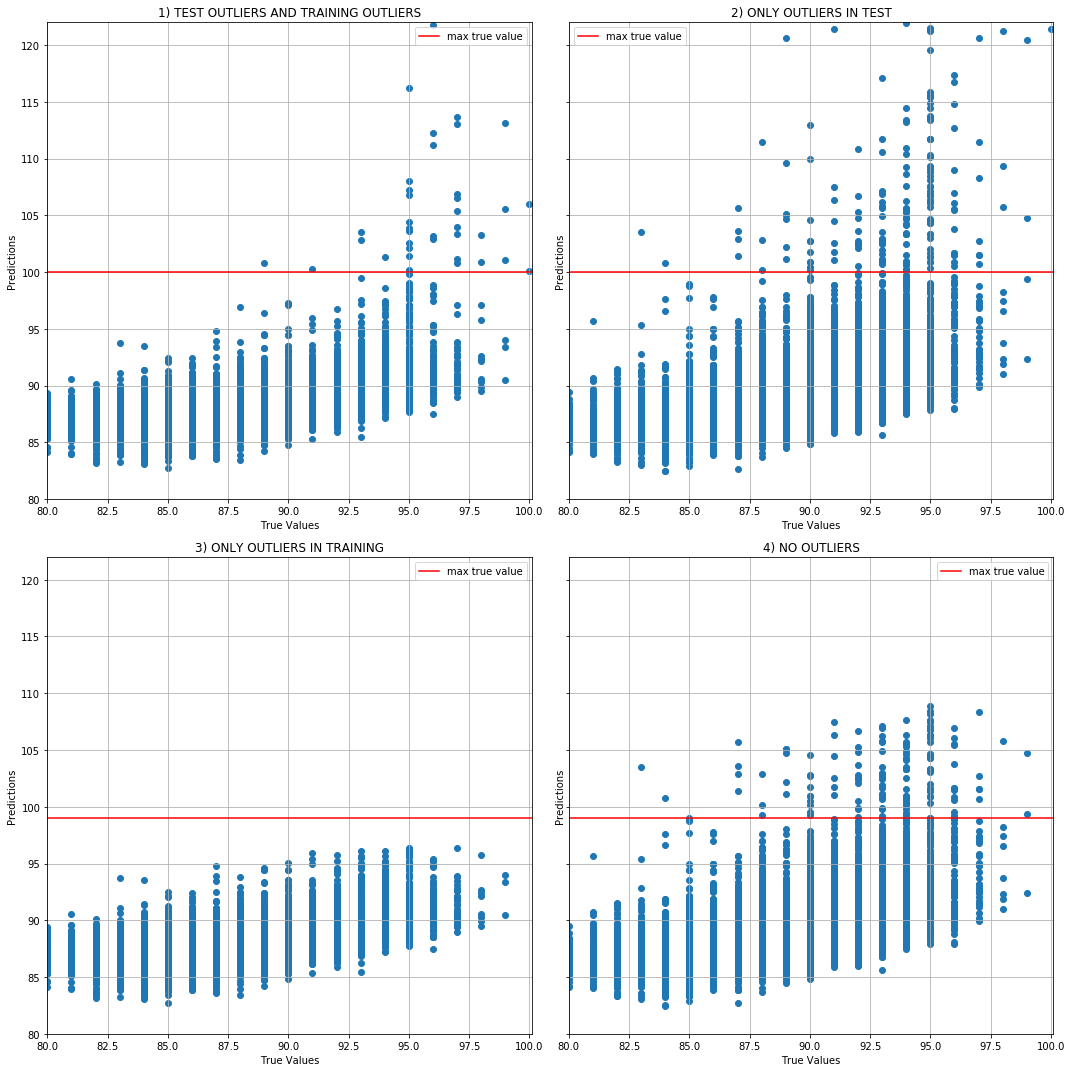

In [463]:
f, ((ax3, ax4), (ax1, ax2)) = plt.subplots(2, 2, sharey=True, figsize=(15,15))

# Dirty test outliers
print("************OUTLIERS IN TEST DATA **************")
# plot w/ outliers in training data
ax3.scatter(ax3_y_test, ax3_y_predictions)
ax3.set(xlabel='True Values', ylabel='Predictions')

max_y_predictions = int(max(ax3_y_predictions))
min_y_predictions = int(min(ax3_y_predictions))

print("--> TEST OUTLIERS AND TRAINING OUTLIERS")
print('max_y_predictions: ', max_y_predictions)
print('min_y_predictions: ', min_y_predictions)
print('MAE:', mae_3)
print()

max_y_true = int(max(ax3_y_test.points))
min_y_true = int(min(ax3_y_test.points))

ax3.axhline(max_y_true,label='max true value', color="red")

ax3.legend()
ax3.grid()
ax3.set_xlim([80,100+0.1])
ax3.set_ylim([80,120+2])
ax3.set_title('1) TEST OUTLIERS AND TRAINING OUTLIERS')

# plot w/o outliers in training data
ax4.scatter(ax4_y_test, ax4_y_predictions)
ax4.set(xlabel='True Values', ylabel='Predictions')

max_y_predictions = int(max(ax4_y_predictions))
min_y_predictions = int(min(ax4_y_predictions))

print("--> ONLY OUTLIERS IN TEST")
print('max_y_predictions: ', max_y_predictions)
print('min_y_predictions: ', min_y_predictions)
print('MAE:', mae_4)

max_y_true = int(max(ax4_y_test.points))
min_y_true = int(min(ax4_y_test.points))

ax4.axhline(max_y_true,label='max true value', color="red")

ax4.legend()
ax4.grid()
ax4.set_xlim([80,100+0.1])
ax4.set_ylim([80,120+2])
ax4.set_title('2) ONLY OUTLIERS IN TEST')

# plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.5, hspace=None)

print()

# Clean test
print("************CLEAN TEST DATA**************")
# plot w/ outliers in training data
ax1.scatter(ax1_y_test, ax1_y_predictions)
ax1.set(xlabel='True Values', ylabel='Predictions')

max_y_predictions = int(max(ax1_y_predictions))
min_y_predictions = int(min(ax1_y_predictions))

print("--> ONLY OUTLIERS IN TRAINING:")
print('max_y_predictions: ', max_y_predictions)
print('min_y_predictions: ', min_y_predictions)
print('MAE:', mae_1)
print()

max_y_true = int(max(ax1_y_test.points))
min_y_true = int(min(ax1_y_test.points))

ax1.axhline(max_y_true,label='max true value', color="red")

ax1.legend()
ax1.grid()
ax1.set_xlim([80,100+0.1])
ax1.set_ylim([80,120+2])
ax1.set_title('3) ONLY OUTLIERS IN TRAINING')

# plot w/o outliers in training data
ax2.scatter(ax2_y_test, ax2_y_predictions)
ax2.set(xlabel='True Values', ylabel='Predictions')

max_y_predictions = int(max(ax2_y_predictions))
min_y_predictions = int(min(ax2_y_predictions))

print("--> NO OUTLIERS:")
print('max_y_predictions: ', max_y_predictions)
print('min_y_predictions: ', min_y_predictions)
print('MAE:', mae_2)

max_y_true = int(max(ax2_y_test.points))
min_y_true = int(min(ax2_y_test.points))

ax2.axhline(max_y_true,label='max true value', color="red")

ax2.legend()
ax2.grid()
ax2.set_xlim([80,100+0.1])
ax2.set_ylim([80,120+2])
ax2.set_title('4) NO OUTLIERS')

plt.tight_layout()

# plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.5, hspace=None)